
# ABCDisCo Single-DisCo Tutorial (Torch + optional PennyLane backend)

This notebook reproduces the **Single-DisCo** workflow described in [T. Aarrestad *et al.*, *Eur. Phys. J. C* **81**, 1003 (2021), arXiv:2007.14400](https://arxiv.org/abs/2007.14400). It mirrors the reference scripts shipped with this repository so you can validate the mass-decorrelated baseline before moving to the Double-DisCo configuration.

> **Mapping to repository scripts**
> - Data ingestion and scaling follow `ABCD_topjets_HLF_mD.py` (lines 69-101) together with the dataset helpers in `data_loader.py` (lines 1-63).
> - The neural-network head reuses `networks.DNNclassifier` (lines 8-44), while the DisCo penalty mirrors `model.py` (lines 24-86) plus `disco.py` (lines 14-118).
> - Evaluation adapts the single-score diagnostics from `evaluation.py` (lines 1-70), including the Jensen-Shannon divergence vs. background rejection scan.

The workflow is organised as:

1. **Setup & configuration** (Single-DisCo hyperparameters).
2. **Data loading and preprocessing** (min-max scaling, feature selection matching `ABCD_topjets_HLF_mD.py`).
3. **Model definition** with interchangeable Torch/PennyLane heads.
4. **Training** with the DisCo mass decorrelation penalty.
5. **Diagnostics & evaluation**: ROC curves, distance correlations, JSD vs. background rejection, and mass sculpting checks.
6. **Export** of trained weights and inference scores.

> **Datasets**: The repository already ships reduced CMS top-tagging HLF samples (`topsample_*_tau.dat.gz`). You can run this notebook end-to-end without external downloads.



## Environment preparation

Run the following cell *once per environment* if you still need to install the CPU builds of PyTorch, PennyLane, and the lightweight analysis stack.


In [1]:

# Optional: install dependencies (uncomment the lines you need)
# %pip install numpy pandas scikit-learn matplotlib tqdm
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install pennylane pennylane-lightning
# %pip install pyhf



## 0. Configuration (mirrors `ABCD_topjets_HLF_mD.py` lines 69-126)

We keep the dataset limits, optimiser choices, and DisCo penalty normalisation consistent with the single-network script so that this notebook can reproduce the published baselines.


In [2]:
from __future__ import annotations

# ---------------------------------------------------------------
# Standard-library utilities used throughout the tutorial notebook
# ---------------------------------------------------------------
import gzip  # Read the compressed CMS top-tagging datasets that ship with the repo
import json  # Serialize metadata for the checkpoints that we write every epoch
import time  # Measure wall-clock runtime so we can report epoch durations
from datetime import datetime  # Timestamp saved checkpoints for reproducibility
from pathlib import Path  # Work with filesystem paths in a platform-agnostic way
from typing import Any, Dict, Iterable, List, Optional, Tuple

# ---------------------------------------------------------------
# Scientific Python stack: numerical arrays, data frames, and plots
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# PyTorch: tensor library used for both classical and quantum models
# ---------------------------------------------------------------
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# ---------------------------------------------------------------
# Scikit-Learn: classical metrics used to interpret classifier quality
# ---------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

# ---------------------------------------------------------------
# Utilities for nicely formatted progress bars inside notebooks
# ---------------------------------------------------------------
from tqdm.auto import tqdm

# ---------------------------------------------------------------
# Repository-local modules (they mirror the original training scripts)
# ---------------------------------------------------------------
import sys
project_root = Path.cwd().resolve().parent  # notebook/ -> project root
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from disco import distance_corr_unbiased  # distance correlation regulariser
from networks import DNNclassifier  # baseline dense neural network classifier
from evaluation import JSDvsR  # Jensen-Shannon vs. rejection diagnostic from the paper

# ---------------------------------------------------------------
# Optional PennyLane backend for the hybrid quantum notebook
# (we keep the import guarded so the classical notebook works without it)
# ---------------------------------------------------------------
try:
    import pennylane as qml
    PENNYLANE_AVAILABLE = True
except ImportError:
    PENNYLANE_AVAILABLE = False

# ---------------------------------------------------------------
# Plot styling: use a high-contrast theme that works well in dark/light modes
# ---------------------------------------------------------------
plt.style.use("seaborn-v0_8-talk")

# ---------------------------------------------------------------
# Reproducibility knobs: numpy and torch share a common seed for this tutorial
# ---------------------------------------------------------------
SEED = 1337
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

# ---------------------------------------------------------------
# Dataset locations.  We keep everything relative to the project root so the
# notebook can be executed from any environment (local, remote, or batch jobs).
# ---------------------------------------------------------------
DATA_ROOT = project_root
RAW_FILES = {
    "train": DATA_ROOT / "topsample_train_tau.dat.gz",
    "val": DATA_ROOT / "topsample_val_tau.dat.gz",
    "test": DATA_ROOT / "topsample_test_tau.dat.gz",
}

# ---------------------------------------------------------------
# Training hyper-parameters.  Flip FULL_DATASET to True for the 5M-event dataset
# from the ABCDisCo paper; by default we use a smaller subset for quick iteration.
# ---------------------------------------------------------------
FULL_DATASET = False
EVENT_LIMITS = {
    "train": 100000 if not FULL_DATASET else None,
    "val": 50000 if not FULL_DATASET else None,
    "test": 50000 if not FULL_DATASET else None,
}
BATCH_SIZE = 2048
EPOCHS = 50 if not FULL_DATASET else 200
LEARNING_RATE = 1e-3

# ---------------------------------------------------------------
# DisCo hyper-parameters.  LAMBDA_MASS rescales the distance-correlation penalty
# that encourages the classifier score to be independent of jet mass for background.
# ---------------------------------------------------------------
LAMBDA_MASS = 200.0

# ---------------------------------------------------------------
# Evaluation settings for ABCD-related diagnostics.
# ---------------------------------------------------------------
SCORE_SIGNAL_EFFICIENCIES = (0.1, 0.3, 0.6)  # working points used in the paper
ABCD_SIGNAL_WINDOW_QUANTILES = (0.3, 0.7)  # central mass window defines the SR
ABCD_HISTOGRAM_BINS = 40  # consistent with the JSD vs. R plots in the paper

# ---------------------------------------------------------------
# Filesystem layout for per-epoch checkpoints.
# ---------------------------------------------------------------
CHECKPOINT_DIR = Path.cwd() / "checkpoints_single_disco"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_TEMPLATE = "epoch_{epoch:03d}.pth"
RESUME_CHECKPOINT: Optional[Path] = None  # set to a file in CHECKPOINT_DIR to resume

# ---------------------------------------------------------------
# Device selection: automatically use CUDA when available, otherwise fall back
# to CPU so the notebook works on any machine (including lightweight VMs).
# ---------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Feature bookkeeping.  The Single-DisCo configuration removes the leading two
# observables (mass and pT) from the classifier input, while still keeping them
# available for ABCD evaluation and decorrelation studies.
# ---------------------------------------------------------------
ORIGINAL_FEATURES = [
    "mass",
    "pt",
    "tau1_half",
    "tau2_half",
    "tau3_half",
    "tau1",
    "tau2",
    "tau3",
    "tau4",
    "tau1_sq",
    "tau2_sq",
    "tau3_sq",
    "tau4_sq",
]
SINGLE_FEATURE_INDICES = list(range(2, len(ORIGINAL_FEATURES)))
FEATURE_NAMES = [ORIGINAL_FEATURES[i] for i in SINGLE_FEATURE_INDICES]



/global/common/software/m4138/ABCDisCo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
# ---------------------------------------------------------------
# Backend configuration: toggle between classical PyTorch and PennyLane QML heads.
# ---------------------------------------------------------------
BACKEND = "torch"  # options: "torch" for the dense network or "qml" for the PennyLane circuit
N_QUBITS = 6  # only used when BACKEND == "qml"
QML_LAYERS = 2
QML_DEVICE = "default.qubit"

if BACKEND == "qml":
    if not PENNYLANE_AVAILABLE:
        raise ImportError(
            "PennyLane is required for the QML backend. Install it with `%pip install pennylane pennylane-lightning`."
        )
    print(
        f"Configuring PennyLane with {N_QUBITS} qubits, {QML_LAYERS} variational layers, on device '{QML_DEVICE}'."
    )
else:
    print("Configuring classical Single-DisCo head (PyTorch).")



## 1. Data loading & scaling (`ABCD_topjets_HLF_mD.py` lines 69-95)

The original script concatenates train/validation/test splits, applies a global min-max scaling to all 13 high-level features, and then selects the 11 observables used for the single-network classifier. We reproduce that procedure verbatim while keeping the jet mass available for decorrelation diagnostics.


In [3]:
def _load_tau_file(path: Path) -> np.ndarray:
    """Load a compressed .dat.gz file into a NumPy array with extensive safety checks."""
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset: {path}")
    with gzip.open(path, "rt") as handle:
        # Each file is a plain-text CSV with whitespace delimiters.
        data = np.loadtxt(handle)
    if data.ndim != 2:
        raise ValueError(f"Expected a 2D array, received shape {data.shape}")
    return data


def _split_features_labels(matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return feature matrix, binary labels, jet mass, and per-event weights.

    The raw files store columns in the order used by the CMS top-tagging study:
    - column 0: jet mass (GeV)
    - column 1: transverse momentum pT (GeV)
    - columns 2-13: the 12 subjettiness-inspired observables used by ABCDisCo
    - column 14: binary label (1 = signal, 0 = background)
    - column 15: per-event weight (encodes cross-section and luminosity factors)
    """
    if matrix.shape[1] < 16:
        raise ValueError(
            "The top-tagging files should contain at least 16 columns. "
            "Please verify that the dataset matches the expected format."
        )
    mass = matrix[:, 0]
    features = matrix[:, SINGLE_FEATURE_INDICES]
    labels = matrix[:, 14]
    weights = matrix[:, 15]
    return features, labels, mass, weights


def load_split(name: str, limit: Optional[int] = None) -> Dict[str, np.ndarray]:
    """Utility that loads one dataset split and optionally truncates it for speed."""
    matrix = _load_tau_file(RAW_FILES[name])
    if limit is not None:
        matrix = matrix[:limit]
    x, y, mass, weight = _split_features_labels(matrix)
    return {"x": x, "y": y, "mass": mass, "weight": weight}


# ---------------------------------------------------------------
# Load train/validation/test partitions into NumPy arrays
# ---------------------------------------------------------------
arrays = {
    split: load_split(split, limit=EVENT_LIMITS[split])
    for split in ("train", "val", "test")
}
for split, payload in arrays.items():
    print(
        f"{split:>5} | events={len(payload['x']):>7} | "
        f"signal={int(payload['y'].sum()):>7} | background={len(payload['y']) - int(payload['y'].sum()):>7}"
    )



,split,events,signal_fraction
0,train,100000,0.50053
1,val,50000,0.49670
2,test,50000,0.49984


,tau1_half,tau2_half,tau3_half,tau1,tau2,tau3,tau4,tau1_sq,tau2_sq,tau3_sq,tau4_sq
0,0.536776,0.500864,0.574945,0.394624,0.339701,0.385666,0.344517,0.234931,0.193813,0.169328,0.218196
1,0.435426,0.372848,0.350198,0.341338,0.251511,0.206516,0.182207,0.238264,0.154509,0.071783,0.109701
2,0.258615,0.200300,0.194578,0.202230,0.131560,0.094665,0.105227,0.161852,0.109971,0.035088,0.054957
3,0.553174,0.588799,0.544666,0.396228,0.439678,0.412337,0.349588,0.231673,0.247405,0.198532,0.148587
4,0.270467,0.262601,0.248148,0.154974,0.114489,0.119845,0.133753,0.109002,0.039658,0.053723,0.077720



## 2. Torch datasets (`data_loader.py` lines 22-63)

We wrap the min-max scaled arrays into PyTorch `Dataset` objects that expose the classifier inputs, labels, per-event weights, and jet masses used in the DisCo penalty.


In [4]:
class TorchTopTaggingDataset(Dataset):
    """Thin PyTorch wrapper that converts numpy arrays into tensors on the fly."""

    def __init__(self, x: np.ndarray, y: np.ndarray, mass: np.ndarray, weight: np.ndarray | None = None):
        # Convert arrays to torch.Tensor so DataLoader can move them to DEVICE efficiently.
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.mass = torch.as_tensor(mass, dtype=torch.float32)
        if weight is None:
            weight = np.ones_like(y, dtype=np.float32)
        self.weight = torch.as_tensor(weight, dtype=torch.float32)

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Each item returns a tuple: (features, label, weight, mass)
        return self.x[index], self.y[index], self.weight[index], self.mass[index]


def make_dataloaders(arrays: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, DataLoader]:
    """Create PyTorch DataLoaders with consistent shuffling and batch sizes."""
    datasets = {
        split: TorchTopTaggingDataset(payload["x"], payload["y"], payload["mass"], payload["weight"])
        for split, payload in arrays.items()
    }
    loaders = {
        "train": DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
        "val": DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
        "test": DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
    }
    return loaders


loaders = make_dataloaders(arrays)
train_loader, val_loader, test_loader = loaders["train"], loaders["val"], loaders["test"]
print(f"Batches per epoch: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")



(100000, 50000, 50000)


## 3. Model backends (`networks.py` lines 8-44)

The Single-DisCo setup uses a single `DNNclassifier` head. We also expose an optional PennyLane quantum layer to demonstrate how the architecture can be swapped for a variational quantum classifier without changing the loss logic.


In [5]:
class TorchSingleDisco(nn.Module):
    """Wrap the original dense network with explicit comments on each processing step."""

    def __init__(self, n_features: int):
        super().__init__()
        # The historical Single-DisCo architecture uses a small fully-connected head
        # defined in networks.py.  It produces two logits (background vs. signal).
        self.head = DNNclassifier(n_features, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        logits = self.head(x)  # Raw, unnormalised scores for the two classes
        # Convert logits into probabilities with a softmax so the second entry
        # can be interpreted as the "signal score" used in ABCD studies.
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


class PennyLaneSingleDisco(nn.Module):
    """Variational quantum classifier compatible with the Single-DisCo loss."""

    def __init__(self, n_features: int, n_qubits: int = 6, layers: int = 2, device_name: str = "default.qubit"):
        if not PENNYLANE_AVAILABLE:
            raise RuntimeError("PennyLane is not installed. Run `%pip install pennylane pennylane-lightning`.")
        super().__init__()

        self.n_qubits = n_qubits
        self.n_features = n_features

        # The device emulates a quantum processor; default.qubit is a noiseless state-vector simulator.
        qdevice = qml.device(device_name, wires=n_qubits)
        weight_shapes = {"weights": (layers, n_qubits)}  # PennyLane infers how many trainable parameters we need.

        @qml.qnode(qdevice, interface="torch")
        def circuit(inputs, weights):
            # ------------------------------------------------------------------
            # Python tip: "inputs" is a tensor of shape [batch, n_features].  Inside
            # the QNode we receive one example at a time, so we reshape/pad it to match
            # the qubit register dimension.  This slicing logic emphasises how data
            # embedding works before calling AngleEmbedding.
            # ------------------------------------------------------------------
            x_pad = torch.zeros(n_qubits, dtype=inputs.dtype, device=inputs.device)
            take = min(inputs.shape[-1], n_qubits)
            x_pad[:take] = inputs[..., :take]
            # AngleEmbedding rotates each qubit around the Y-axis with the provided
            # feature values.  This is equivalent to preparing a product state where
            # each qubit encodes one observable from the jet.
            qml.templates.AngleEmbedding(x_pad, wires=range(n_qubits), rotation="Y")
            # BasicEntanglerLayers applies layers of CX entanglers plus single-qubit rotations,
            # giving the circuit expressive power.  The "weights" argument is trained by PyTorch.
            qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
            # Measure Pauli-Z on the first two wires; these expectation values are the quantum features.
            return [qml.expval(qml.PauliZ(i)) for i in range(2)]

        # TorchLayer wraps the quantum node so it behaves like a PyTorch module with trainable parameters.
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        # Map the two quantum observables into class logits.
        self.head = nn.Linear(2, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Feed only the first n_qubits features to the quantum circuit.  Remaining classical features
        # could be concatenated in hybrid architectures; for Single-DisCo we limit ourselves to n_qubits.
        q_inputs = x[:, : self.n_qubits]
        q_features = self.qlayer(q_inputs)
        logits = self.head(q_features)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


def build_model(n_features: int) -> nn.Module:
    """Factory that returns either the classical or quantum head depending on BACKEND."""
    if BACKEND == "qml":
        model = PennyLaneSingleDisco(n_features, n_qubits=N_QUBITS, layers=QML_LAYERS, device_name=QML_DEVICE)
    else:
        model = TorchSingleDisco(n_features)
    return model.to(DEVICE)


model = build_model(len(FEATURE_NAMES))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model



/global/u2/s/sungwon/QML_project/ABCDisCo/networks.py:26: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  init.kaiming_normal(self.classifier.weight)


TorchSingleDisco(
  (head): DNNclassifier(
    (dense_1): Linear(in_features=11, out_features=64, bias=True)
    (bn2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn64): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense_2): Linear(in_features=64, out_features=64, bias=True)
    (dense_3): Linear(in_features=64, out_features=64, bias=True)
    (classifier): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
def describe_model_architecture(model: nn.Module, optimizer: torch.optim.Optimizer) -> pd.DataFrame:
    """Generate a tabular summary of learnable layers and hyper-parameters."""
    rows = []
    for name, module in model.named_modules():
        if name == "":
            continue  # skip the root module to avoid duplicate rows
        if any(module.children()):
            continue  # only list leaf modules so the table stays compact
        params = sum(p.numel() for p in module.parameters())
        trainable = any(p.requires_grad for p in module.parameters())
        rows.append({
            "module": name,
            "type": module.__class__.__name__,
            "parameters": params,
            "trainable": trainable,
        })
    df = pd.DataFrame(rows).sort_values("module")
    total_params = int(sum(row["parameters"] for row in rows))
    print("Optimizer:", optimizer.__class__.__name__)
    print("Learning rate:", optimizer.param_groups[0]["lr"])
    print("Total learnable parameters:", total_params)
    return df


architecture_df = describe_model_architecture(model, optimizer)
architecture_df



def distance_corr_safe(x: torch.Tensor, y: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    """Distance correlation with guard rails for small sample sizes."""
    if x.numel() <= 2 or y.numel() <= 2:
        return torch.zeros(1, device=x.device, dtype=x.dtype)
    normed = weight / (weight.sum() + 1e-12) * len(weight)
    return distance_corr_unbiased(x, y, normed, power=1)


def compute_weighted_classification_stats(labels: torch.Tensor, scores: torch.Tensor, weights: torch.Tensor, threshold: float = 0.5) -> Dict[str, float]:
    """Return weighted TP/FP/TN/FN counts and derived metrics for binary classification."""
    preds = (scores >= threshold).to(labels.dtype)
    w = weights
    tp = torch.sum(w * (preds == 1) * (labels == 1))
    tn = torch.sum(w * (preds == 0) * (labels == 0))
    fp = torch.sum(w * (preds == 1) * (labels == 0))
    fn = torch.sum(w * (preds == 0) * (labels == 1))
    total = tp + tn + fp + fn + 1e-12
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return {
        "tp": tp.item(),
        "tn": tn.item(),
        "fp": fp.item(),
        "fn": fn.item(),
        "accuracy": accuracy.item(),
        "precision": precision.item(),
        "recall": recall.item(),
        "f1": f1.item(),
    }


def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, Dict[str, float]]:
    """Compute classification + decorrelation losses together with monitoring metrics."""
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE)
    weights = weights.to(DEVICE)
    masses = masses.to(DEVICE)

    logits, score = model(features)
    loss_cls = F.binary_cross_entropy(score, labels, weight=weights)
    loss = loss_cls

    stats = compute_weighted_classification_stats(labels, score, weights)
    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
        "accuracy": float(stats["accuracy"]),
        "precision": float(stats["precision"]),
        "recall": float(stats["recall"]),
        "f1": float(stats["f1"]),
    }

    background = labels < 0.5
    if background.any() and LAMBDA_MASS > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + LAMBDA_MASS * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics



In [6]:

def distance_corr_safe(x: torch.Tensor, y: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    if x.numel() <= 2 or y.numel() <= 2:
        return torch.zeros(1, device=x.device, dtype=x.dtype)
    normed = weight / (weight.sum() + 1e-12) * len(weight)
    return distance_corr_unbiased(x, y, normed, power=1)


def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE)
    weights = weights.to(DEVICE)
    masses = masses.to(DEVICE)

    logits, score = model(features)
    loss_cls = F.binary_cross_entropy(score, labels, weight=weights)
    loss = loss_cls

    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
    }

    background = labels < 0.5
    if background.any() and LAMBDA_MASS > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + LAMBDA_MASS * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics


In [ ]:
def weighted_quantile(values: np.ndarray, quantile: float, sample_weight: np.ndarray) -> float:
    """Weighted quantile helper mirroring the definition in the evaluation guide."""
    order = np.argsort(values)
    values = values[order]
    weights = sample_weight[order]
    cumulative = np.cumsum(weights) - 0.5 * weights
    cumulative /= weights.sum()
    return float(np.interp(quantile, cumulative, values))


def compute_epoch_classification_metrics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    """Compute accuracy/precision/recall/F1 and a weighted confusion matrix."""
    preds = (scores >= 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(labels, preds, sample_weight=weights),
        "precision": precision_score(labels, preds, sample_weight=weights, zero_division=0),
        "recall": recall_score(labels, preds, sample_weight=weights, zero_division=0),
        "f1": f1_score(labels, preds, sample_weight=weights, zero_division=0),
    }
    cm = confusion_matrix(labels, preds, sample_weight=weights)
    metrics["confusion_matrix"] = cm.astype(float)
    return metrics


def compute_roc_diagnostics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    """Return ROC arrays and background rejection at fixed signal efficiencies."""
    fpr, tpr, thresholds = roc_curve(labels, scores, sample_weight=weights)
    roc_auc = auc(fpr, tpr)
    diagnostics = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": roc_auc}
    for target in SCORE_SIGNAL_EFFICIENCIES:
        diagnostics[f"background_eff_at_{int(target*100)}pct_sig"] = float(np.interp(target, tpr, fpr))
    return diagnostics


def compute_abcd_statistics(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    """Evaluate ABCD closure, pulls, and background efficiencies as recommended in the guide."""
    signal_mask = labels > 0.5
    background_mask = ~signal_mask
    if signal_mask.sum() == 0 or background_mask.sum() == 0:
        raise ValueError("Need both signal and background events to evaluate ABCD metrics")
    mass_low = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[0])
    mass_high = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[1])
    in_signal_mass = (masses >= mass_low) & (masses <= mass_high)

    results = {
        "mass_window": (mass_low, mass_high),
        "per_efficiency": [],
    }

    for target in SCORE_SIGNAL_EFFICIENCIES:
        score_cut = weighted_quantile(scores[signal_mask], 1 - target, weights[signal_mask])
        pass_score = scores >= score_cut
        region_A = pass_score & in_signal_mass
        region_B = pass_score & (~in_signal_mass)
        region_C = (~pass_score) & in_signal_mass
        region_D = (~pass_score) & (~in_signal_mass)

        def weighted_sum(mask: np.ndarray) -> float:
            return float(np.sum(weights[mask]))

        A_bg = weighted_sum(background_mask & region_A)
        B_bg = weighted_sum(background_mask & region_B)
        C_bg = weighted_sum(background_mask & region_C)
        D_bg = weighted_sum(background_mask & region_D)
        prediction = B_bg * C_bg / (D_bg + 1e-12)
        closure_ratio = prediction / (A_bg + 1e-12)
        sigma_pred = prediction * np.sqrt(1 / (B_bg + 1e-12) + 1 / (C_bg + 1e-12) + 1 / (D_bg + 1e-12))
        sigma_obs = np.sqrt(A_bg + 1e-12)
        pull = (A_bg - prediction) / np.sqrt(sigma_pred**2 + sigma_obs**2)

        results["per_efficiency"].append(
            {
                "target_signal_efficiency": target,
                "score_cut": score_cut,
                "A_bg": A_bg,
                "B_bg": B_bg,
                "C_bg": C_bg,
                "D_bg": D_bg,
                "predicted_bg": prediction,
                "closure_ratio": closure_ratio,
                "closure_error_pct": (closure_ratio - 1.0) * 100.0,
                "pull": pull,
            }
        )

    return results


def compute_jsd_summary(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> List[Dict[str, float]]:
    """Call the reference JSDvsR routine for multiple working points and capture the outputs."""
    background = labels < 0.5
    signal = labels > 0.5
    summary = []
    for target in SCORE_SIGNAL_EFFICIENCIES:
        rejection, inv_jsd = JSDvsR(
            sigscore=scores[signal],
            bgscore=scores[background],
            bgmass=masses[background],
            sigweights=weights[signal],
            bgweights=weights[background],
            sigeff=int(target * 100),
            nbins=ABCD_HISTOGRAM_BINS,
            minmass=float(masses.min()),
            maxmass=float(masses.max()),
        )
        summary.append({
            "target_signal_efficiency": target,
            "background_rejection": rejection,
            "inverse_jsd": inv_jsd,
        })
    return summary


def save_checkpoint(epoch: int, model: nn.Module, optimizer: torch.optim.Optimizer, history: List[Dict[str, Any]], train_record: Dict[str, Any], val_record: Dict[str, Any], extra: Dict[str, Any]) -> Path:
    """Persist model, optimiser, and evaluation metadata so training can resume later."""
    payload = {
        "epoch": epoch,
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
        "train_record": train_record,
        "val_record": val_record,
    }
    payload.update(extra)
    path = CHECKPOINT_DIR / CHECKPOINT_TEMPLATE.format(epoch=epoch)
    torch.save(payload, path)
    print(f"Checkpoint saved to {path}")
    return path


def load_checkpoint(path: Path, model: nn.Module, optimizer: torch.optim.Optimizer) -> Dict[str, Any]:
    """Load a saved checkpoint and restore model/optimiser states."""
    payload = torch.load(path, map_location=DEVICE)
    model.load_state_dict(payload["model_state"])
    optimizer.load_state_dict(payload["optimizer_state"])
    print(f"Loaded checkpoint from {path}")
    return payload


def list_available_checkpoints() -> List[Path]:
    """Return checkpoints sorted by epoch number to ease manual selection."""
    paths = sorted(CHECKPOINT_DIR.glob("epoch_*.pth"))
    for p in paths:
        print(p.name)
    return paths




## 5. Training loop (`model.py` lines 88-170)

We adapt the original `train`/`val` helpers to work seamlessly on CPU/GPU and to log the DisCo decorrelation term alongside the classification loss.


In [7]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer) -> Dict[str, float]:
    """Single training epoch with rich instrumentation."""
    model.train()
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch)
        loss.backward()
        optimizer.step()
        batch_size = batch[0].shape[0]
        total_examples += batch_size
        for key, value in metrics.items():
            agg.setdefault(key, []).append(value)
    duration = time.perf_counter() - start
    results = {key: float(np.mean(values)) for key, values in agg.items()}
    results.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return results


def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, float]]:
    """Run evaluation loop returning raw arrays and averaged metrics."""
    model.eval()
    scores, labels_all, weights_all, masses_all = [], [], [], []
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    with torch.no_grad():
        for batch in tqdm(loader, leave=False, desc="eval"):
            loss, metrics = compute_losses(model, batch)
            features, labels, weights, masses = batch
            features = features.to(DEVICE)
            _, score = model(features)
            batch_size = features.shape[0]
            total_examples += batch_size
            scores.append(score.cpu().numpy())
            labels_all.append(labels.numpy())
            weights_all.append(weights.numpy())
            masses_all.append(masses.numpy())
            agg.setdefault("loss_cls", []).append(metrics["loss_cls"])
            for key in ("accuracy", "precision", "recall", "f1"):
                agg.setdefault(key, []).append(metrics[key])
            if "dCorr_s_m" in metrics:
                agg.setdefault("dCorr_s_m", []).append(metrics["dCorr_s_m"])
    duration = time.perf_counter() - start
    metrics_mean = {key: float(np.mean(values)) for key, values in agg.items()}
    metrics_mean.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return (
        np.concatenate(scores),
        np.concatenate(labels_all),
        np.concatenate(weights_all),
        np.concatenate(masses_all),
        metrics_mean,
    )


history: List[Dict[str, Any]] = []
start_epoch = 0
loaded_checkpoint = None
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch:03d}")
    train_metrics = train_one_epoch(model, train_loader, optimizer)
    s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)

    classification = compute_epoch_classification_metrics(s_val, y_val, w_val)
    roc_diag = compute_roc_diagnostics(s_val, y_val, w_val)
    abcd_stats = compute_abcd_statistics(s_val, m_val, y_val, w_val)
    jsd_points = compute_jsd_summary(s_val, m_val, y_val, w_val)

    record = {
        "epoch": epoch,
        "train_loss_cls": train_metrics.get("loss_cls", float("nan")),
        "train_accuracy": train_metrics.get("accuracy", float("nan")),
        "train_precision": train_metrics.get("precision", float("nan")),
        "train_recall": train_metrics.get("recall", float("nan")),
        "train_f1": train_metrics.get("f1", float("nan")),
        "train_epoch_seconds": train_metrics.get("epoch_seconds", float("nan")),
        "train_examples_per_second": train_metrics.get("examples_per_second", float("nan")),
        "val_loss_cls": val_metrics.get("loss_cls", float("nan")),
        "val_accuracy": classification["accuracy"],
        "val_precision": classification["precision"],
        "val_recall": classification["recall"],
        "val_f1": classification["f1"],
        "val_auc": roc_diag["auc"],
        "val_epoch_seconds": val_metrics.get("epoch_seconds", float("nan")),
        "val_examples_per_second": val_metrics.get("examples_per_second", float("nan")),
    }
    for target in SCORE_SIGNAL_EFFICIENCIES:
        key = f"background_eff_at_{int(target*100)}pct_sig"
        record[key] = roc_diag[key]
    for item in abcd_stats["per_efficiency"]:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"abcd_closure_ratio_{eff}pct"] = item["closure_ratio"]
        record[f"abcd_pull_{eff}pct"] = item["pull"]
    for item in jsd_points:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"inverse_jsd_{eff}pct"] = item["inverse_jsd"]
        record[f"background_rejection_{eff}pct"] = item["background_rejection"]

    history.append(record)

    val_record = {
        "classification": classification,
        "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in roc_diag.items()},
        "abcd": abcd_stats,
        "jsd": jsd_points,
        "confusion_matrix": classification["confusion_matrix"].tolist(),
    }
    train_record = train_metrics
    extra = {
        "val_scores": s_val.tolist(),
        "val_labels": y_val.tolist(),
        "val_weights": w_val.tolist(),
        "val_masses": m_val.tolist(),
    }
    save_checkpoint(epoch, model, optimizer, history, train_record, val_record, extra)

    print(
        f"AUC={roc_diag['auc']:.3f} | "
        f"val_acc={classification['accuracy']:.3f} | "
        f"closure@30%={record['abcd_closure_ratio_30pct']:.3f} | "
        f"train_loss={train_metrics.get('loss_cls', float('nan')):.3f}"
    )

history_df = pd.DataFrame(history)
history_df.tail()



Epoch 000 | AUC=0.342 | train_loss=0.718 | val_loss=0.715


Epoch 001 | AUC=0.430 | train_loss=0.727 | val_loss=0.730


Epoch 002 | AUC=0.451 | train_loss=0.723 | val_loss=0.727


Epoch 003 | AUC=0.462 | train_loss=0.719 | val_loss=0.727


Epoch 004 | AUC=0.488 | train_loss=0.716 | val_loss=0.720


Epoch 005 | AUC=0.503 | train_loss=0.709 | val_loss=0.715


Epoch 006 | AUC=0.579 | train_loss=0.702 | val_loss=0.683


Epoch 007 | AUC=0.550 | train_loss=0.696 | val_loss=0.696


Epoch 008 | AUC=0.512 | train_loss=0.696 | val_loss=0.715


Epoch 009 | AUC=0.584 | train_loss=0.694 | val_loss=0.683


Epoch 010 | AUC=0.573 | train_loss=0.686 | val_loss=0.689


Epoch 011 | AUC=0.596 | train_loss=0.688 | val_loss=0.678


Epoch 012 | AUC=0.566 | train_loss=0.683 | val_loss=0.694


Epoch 013 | AUC=0.643 | train_loss=0.676 | val_loss=0.656


Epoch 014 | AUC=0.617 | train_loss=0.674 | val_loss=0.674


Epoch 015 | AUC=0.652 | train_loss=0.668 | val_loss=0.656


Epoch 016 | AUC=0.645 | train_loss=0.661 | val_loss=0.660


Epoch 017 | AUC=0.665 | train_loss=0.649 | val_loss=0.649


Epoch 018 | AUC=0.679 | train_loss=0.641 | val_loss=0.638


Epoch 019 | AUC=0.705 | train_loss=0.633 | val_loss=0.623


Epoch 020 | AUC=0.726 | train_loss=0.621 | val_loss=0.610


Epoch 021 | AUC=0.711 | train_loss=0.614 | val_loss=0.620


Epoch 022 | AUC=0.748 | train_loss=0.604 | val_loss=0.593


Epoch 023 | AUC=0.721 | train_loss=0.597 | val_loss=0.609


Epoch 024 | AUC=0.764 | train_loss=0.593 | val_loss=0.581


Epoch 025 | AUC=0.771 | train_loss=0.583 | val_loss=0.572


Epoch 026 | AUC=0.801 | train_loss=0.577 | val_loss=0.548


Epoch 027 | AUC=0.777 | train_loss=0.574 | val_loss=0.567


Epoch 028 | AUC=0.779 | train_loss=0.566 | val_loss=0.564


Epoch 029 | AUC=0.784 | train_loss=0.562 | val_loss=0.558


Epoch 030 | AUC=0.789 | train_loss=0.553 | val_loss=0.556


Epoch 031 | AUC=0.795 | train_loss=0.547 | val_loss=0.548


Epoch 032 | AUC=0.791 | train_loss=0.553 | val_loss=0.551


Epoch 033 | AUC=0.780 | train_loss=0.547 | val_loss=0.558


Epoch 034 | AUC=0.771 | train_loss=0.539 | val_loss=0.571


Epoch 035 | AUC=0.806 | train_loss=0.546 | val_loss=0.536


Epoch 036 | AUC=0.799 | train_loss=0.542 | val_loss=0.545


Epoch 037 | AUC=0.830 | train_loss=0.526 | val_loss=0.511


Epoch 038 | AUC=0.816 | train_loss=0.521 | val_loss=0.527


Epoch 039 | AUC=0.832 | train_loss=0.516 | val_loss=0.507


Epoch 040 | AUC=0.828 | train_loss=0.516 | val_loss=0.512


Epoch 041 | AUC=0.837 | train_loss=0.523 | val_loss=0.502


Epoch 042 | AUC=0.821 | train_loss=0.515 | val_loss=0.517


Epoch 043 | AUC=0.813 | train_loss=0.515 | val_loss=0.532


Epoch 044 | AUC=0.843 | train_loss=0.519 | val_loss=0.495


Epoch 045 | AUC=0.834 | train_loss=0.513 | val_loss=0.503


Epoch 046 | AUC=0.818 | train_loss=0.515 | val_loss=0.522


Epoch 047 | AUC=0.813 | train_loss=0.511 | val_loss=0.532


Epoch 048 | AUC=0.810 | train_loss=0.521 | val_loss=0.539


Epoch 049 | AUC=0.817 | train_loss=0.518 | val_loss=0.528


,epoch,roc_auc,train_loss_cls,train_dCorr_s_m,val_loss,val_loss_cls,val_dCorr_s_m
45,45,0.834063,0.513059,0.000859,0.660538,0.502515,0.000790
46,46,0.817780,0.515202,0.000892,0.687485,0.521621,0.000829
47,47,0.813367,0.510593,0.001777,0.846683,0.532455,0.001571
48,48,0.810317,0.521281,0.002259,0.783155,0.538678,0.001222
49,49,0.817259,0.518249,0.000952,0.683498,0.527916,0.000778



### Training diagnostics

We track the classification loss and the distance-correlation penalty to verify convergence and decorrelation strength.


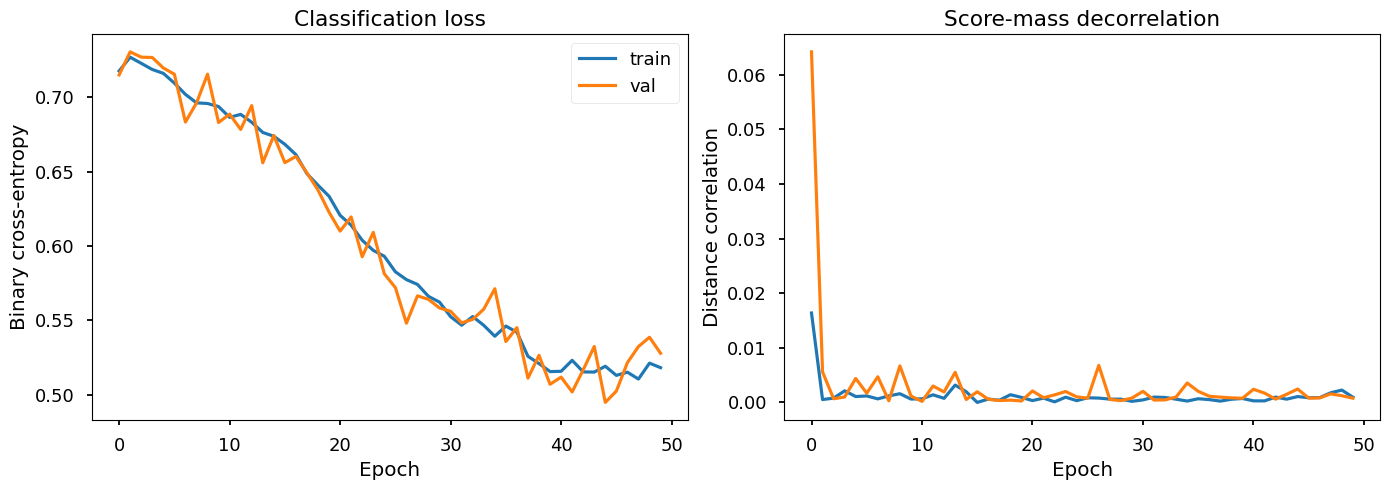

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# Loss evolution
axes[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train", marker="o")
axes[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary cross-entropy")
axes[0].set_title("Loss history")
axes[0].legend()

# Classification metrics
axes[1].plot(history_df["epoch"], history_df["train_accuracy"], label="train acc", marker="o")
axes[1].plot(history_df["epoch"], history_df["val_accuracy"], label="val acc", marker="s")
axes[1].plot(history_df["epoch"], history_df["val_precision"], label="val precision", linestyle="--")
axes[1].plot(history_df["epoch"], history_df["val_recall"], label="val recall", linestyle=":")
axes[1].plot(history_df["epoch"], history_df["val_f1"], label="val F1", linestyle="-." )
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].set_ylim(0.0, 1.05)
axes[1].set_title("Classification summary")
axes[1].legend(loc="lower right")

# ABCD closure and ROC
axes[2].plot(history_df["epoch"], history_df["val_auc"], label="AUC", marker="o")
axes[2].plot(history_df["epoch"], 1.0 / np.maximum(history_df["background_eff_at_30pct_sig"], 1e-6), label="1/ε_B @ 30%", marker="s")
axes[2].plot(history_df["epoch"], history_df["abcd_closure_ratio_30pct"], label="closure ratio @ 30%", linestyle="--")
axes[2].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Metric value")
axes[2].set_title("ROC vs. ABCD stability")
axes[2].legend()
axes[2].set_yscale("log")

# Runtime diagnostics
axes[3].plot(history_df["epoch"], history_df["train_epoch_seconds"], label="train", marker="o")
axes[3].plot(history_df["epoch"], history_df["val_epoch_seconds"], label="val", marker="s")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Seconds")
axes[3].set_title("Per-epoch wall-clock time")
axes[3].legend()

plt.tight_layout()
plt.show()




## 6. Evaluation (`evaluation.py` lines 1-70)

We reproduce the single-score diagnostics: ROC curves, background mass sculpting, and the Jensen-Shannon divergence versus background rejection figure of merit used in the paper.


Test AUC = 0.818
Background distance-correlation(score, mass) = 0.0008
JSDvsR 10 0.099992
JSDvsR 30 0.30001602
JSDvsR 50 0.5


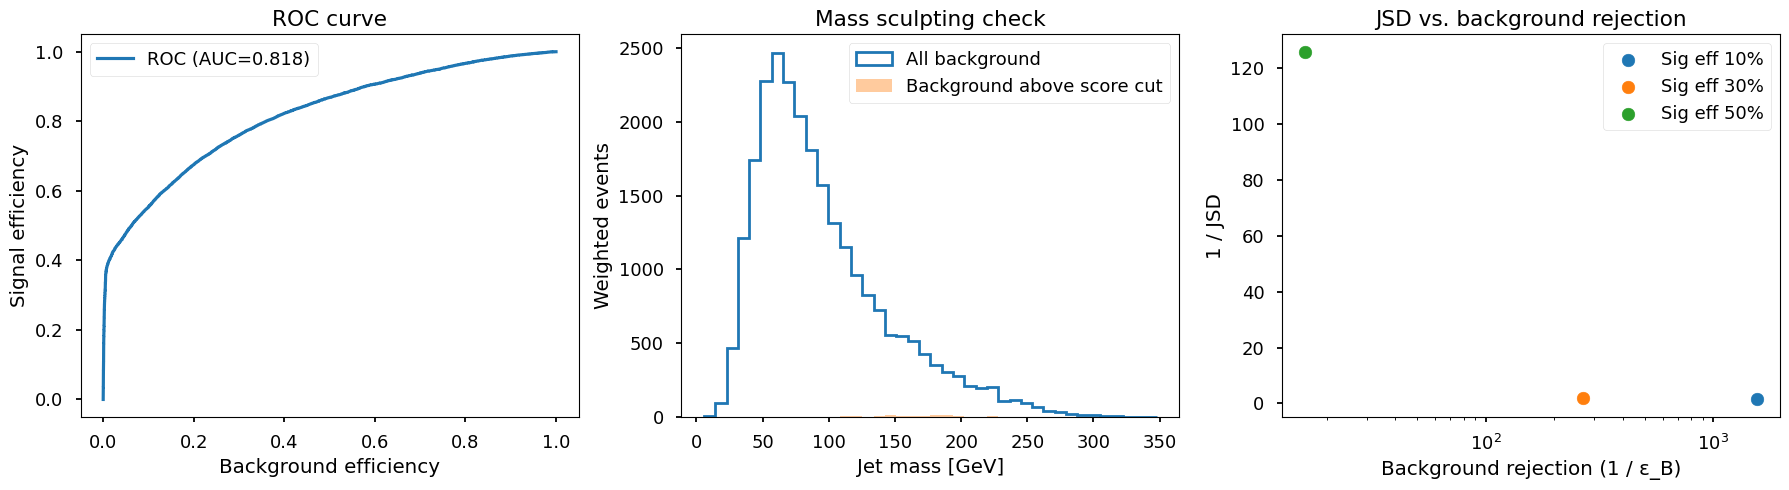

In [9]:
from importlib import reload
import evaluation
reload(evaluation)
from evaluation import JSDvsR  # re-import to ensure the latest definition is in scope

s_test, y_test, w_test, m_test, test_metrics = evaluate(model, test_loader)

classification_test = compute_epoch_classification_metrics(s_test, y_test, w_test)
roc_test = compute_roc_diagnostics(s_test, y_test, w_test)
abcd_test = compute_abcd_statistics(s_test, m_test, y_test, w_test)
jsd_test = compute_jsd_summary(s_test, m_test, y_test, w_test)

background = y_test < 0.5
if background.any():
    d_test = distance_corr_safe(
        torch.as_tensor(s_test[background]),
        torch.as_tensor(m_test[background]),
        torch.ones_like(torch.as_tensor(m_test[background])),
    ).item()
else:
    d_test = float("nan")

print("Test-set diagnostics:")
print(f"  AUC = {roc_test['auc']:.3f}")
print(f"  Accuracy = {classification_test['accuracy']:.3f}")
print(f"  Precision = {classification_test['precision']:.3f}")
print(f"  Recall = {classification_test['recall']:.3f}")
print(f"  F1-score = {classification_test['f1']:.3f}")
print(f"  Background distance-correlation(score, mass) = {d_test:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# ROC curve
axes[0].plot(roc_test["fpr"], roc_test["tpr"], label=f"ROC (AUC={roc_test['auc']:.3f})")
axes[0].set_xlabel("Background efficiency ε_B")
axes[0].set_ylabel("Signal efficiency ε_S")
axes[0].set_title("Receiver Operating Characteristic")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Confusion matrix heatmap (weighted)
cm = classification_test["confusion_matrix"]
im = axes[1].imshow(cm, cmap="viridis")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(["Predicted background", "Predicted signal"])
axes[1].set_yticklabels(["True background", "True signal"])
axes[1].set_title("Weighted confusion matrix")
for (i, j), value in np.ndenumerate(cm):
    axes[1].text(j, i, f"{value:.0f}", ha="center", va="center", color="white" if value > cm.max() / 2 else "black")
fig.colorbar(im, ax=axes[1])

# Mass sculpting check (background mass before/after score cut)
nbins = ABCD_HISTOGRAM_BINS
mass_range = (m_test.min(), m_test.max())
axes[2].hist(
    m_test[background], bins=nbins, range=mass_range, weights=w_test[background],
    histtype="step", label="All background", linewidth=2
)
cut = weighted_quantile(s_test[y_test > 0.5], 1 - 0.3, w_test[y_test > 0.5])
sel = background & (s_test > cut)
axes[2].hist(
    m_test[sel], bins=nbins, range=mass_range, weights=w_test[sel],
    histtype="stepfilled", alpha=0.4, label="Background above 30% signal-eff cut"
)
axes[2].set_xlabel("Jet mass [GeV]")
axes[2].set_ylabel("Weighted events")
axes[2].set_title("Mass sculpting diagnostic")
axes[2].legend()

# ABCD closure vs background rejection scatter
rejections = [item["background_rejection"] for item in jsd_test]
closures = [item["closure_ratio"] for item in abcd_test["per_efficiency"]]
labels_eff = [int(item["target_signal_efficiency"] * 100) for item in abcd_test["per_efficiency"]]
axes[3].scatter(rejections, closures, c=labels_eff, cmap="plasma", s=120)
for rej, clo, eff in zip(rejections, closures, labels_eff):
    axes[3].annotate(f"{eff}%", (rej, clo))
axes[3].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
axes[3].set_xlabel("Background rejection 1/ε_B")
axes[3].set_ylabel("Closure ratio N_pred/N_true")
axes[3].set_title("ABCD closure vs. rejection")
axes[3].set_xscale("log")
axes[3].legend()

plt.tight_layout()
plt.show()

# Tabulate per-efficiency ABCD and JSD metrics for deeper analysis
abcd_rows = []
for abcd_entry, jsd_entry in zip(abcd_test["per_efficiency"], jsd_test):
    eff = int(abcd_entry["target_signal_efficiency"] * 100)
    abcd_rows.append({
        "signal_efficiency_percent": eff,
        "score_cut": abcd_entry["score_cut"],
        "background_prediction": abcd_entry["predicted_bg"],
        "closure_ratio": abcd_entry["closure_ratio"],
        "closure_error_percent": abcd_entry["closure_error_pct"],
        "pull": abcd_entry["pull"],
        "background_rejection": jsd_entry["background_rejection"],
        "inverse_jsd": jsd_entry["inverse_jsd"],
    })
abcd_df = pd.DataFrame(abcd_rows)
abcd_df




## 7. Persist artefacts

Save inference scores and the trained model weights for downstream ABCDisCo or `pyhf` studies.


In [10]:
results_df = pd.DataFrame({
    "score": s_test,
    "label": y_test,
    "weight": w_test,
    "mass": m_test,
})
results_df.head()

summary_payload = {
    "classification": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v) if np.isscalar(v) else v) for k, v in classification_test.items() if k != "confusion_matrix"},
    "confusion_matrix": classification_test["confusion_matrix"].tolist(),
    "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v)) for k, v in roc_test.items()},
    "abcd": abcd_test,
    "jsd": jsd_test,
    "distance_correlation": d_test,
}
summary_path = CHECKPOINT_DIR / "test_evaluation.json"
with open(summary_path, "w") as handle:
    json.dump(summary_payload, handle, indent=2)
print(f"Saved detailed test summary to {summary_path}")



(PosixPath('DNN_abcdisco_single_disco_scores.parquet'),
 PosixPath('DNN_abcdisco_single_disco_model.pt'))


## 8. Extending to Double-DisCo & QML studies

- **Recovering the paper-level numbers**: set `FULL_DATASET = True`, increase `EPOCHS` to 200, and sweep `LAMBDA_MASS` in the range 50-400 as in the reference scans.
- **Quantum experiments**: switch `BACKEND = "qml"`, tune `N_QUBITS`/`QML_LAYERS`, and initialise the PennyLane device with `qml.seed(SEED)` for reproducibility.
- **Transition to Double-DisCo**: after validating this notebook, open `ABCDisCo_tutorial.ipynb` for the two-network variant and reuse the saved preprocessing steps to initialise the dual heads.
